# Training Gesture Model


Import necessary modules and define wavelet function

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [145]:
import pywt
def wavelet(data, level, wavelet):
    (cA, cD) = pywt.dwt(data, wavelet=wavelet)
    for i in range(1, level):
        (cA, cD) = pywt.dwt(cA, wavelet=wavelet)
    return cA, cD

## Import data and perform wavelet transform

In [181]:
gestures = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]
num_samples = 50
num_gestures = len(gestures)

fulldata = pd.DataFrame(columns = ['aX','aY','aZ','gX','gY','gZ'])
fullwavedata = pd.DataFrame(columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'])
formatdata = pd.DataFrame()
formatwavedata = pd.DataFrame()

labels = []

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        filepath = 'hand/hand_{0}_{1}.csv'.format(gesture, i)
        data = pd.read_csv(filepath, index_col=False)
        wavedata = pd.DataFrame()
        
        level1 = 3
        wavetype1 = 'rbio2.2'
        #Start creating the dataframe with transformed data
        wavedata['aX_A1'], wavedata['aX_D1'] = wavelet(data['aX'], level=level1, wavelet=wavetype1)
        wavedata['aY_A1'], wavedata['aY_D1'] = wavelet(data['aY'], level=level1, wavelet=wavetype1)
        wavedata['aZ_A1'], wavedata['aZ_D1'] = wavelet(data['aZ'], level=level1, wavelet=wavetype1)

        wavedata['gX_A1'], wavedata['gX_D1'] = wavelet(data['gX'], level=level1, wavelet=wavetype1)
        wavedata['gY_A1'], wavedata['gY_D1'] = wavelet(data['gY'], level=level1, wavelet=wavetype1)
        wavedata['gZ_A1'], wavedata['gZ_D1'] = wavelet(data['gZ'], level=level1, wavelet=wavetype1)
        
        level2 = 3
        wavetype2 = 'rbio2.2'

        wavedata['aX_A2'], wavedata['aX_D2'] = wavelet(data['aX'], level=level2, wavelet=wavetype2)
        wavedata['aY_A2'], wavedata['aY_D2'] = wavelet(data['aY'], level=level2, wavelet=wavetype2)
        wavedata['aZ_A2'], wavedata['aZ_D2'] = wavelet(data['aZ'], level=level2, wavelet=wavetype2)

        wavedata['gX_A2'], wavedata['gX_D2'] = wavelet(data['gX'], level=level2, wavelet=wavetype2)
        wavedata['gY_A2'], wavedata['gY_D2'] = wavelet(data['gY'], level=level2, wavelet=wavetype2)
        wavedata['gZ_A2'], wavedata['gZ_D2'] = wavelet(data['gZ'], level=level2, wavelet=wavetype2)
        
        wavelen = len(wavedata)
        
        #create a full dataframe with all the data
        fullwavedata = fullwavedata.append(wavedata)
        fulldata = fulldata.append(data)
        label = gesture
        labels.append(label)
        del data, wavedata

labels = np.array(labels)


## Full Data Processing

Normalize data

In [147]:
fulldata = fulldata.iloc[0:,0:6]
normaldata = (fulldata - fulldata.min()) / (fulldata.max()-fulldata.min())
normaldata.describe()

,aX,aY,aZ,gX,gY,gZ
count,192500.000000,192500.000000,192500.000000,192500.000000,192500.000000,192500.000000
mean,0.400953,0.508082,0.541712,0.499318,0.427822,0.502331
std,0.074306,0.068467,0.085276,0.096042,0.095247,0.095711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.377844,0.486061,0.488569,0.484298,0.406824,0.492653
50%,0.388312,0.508553,0.539899,0.505739,0.420533,0.502602
75%,0.411963,0.535409,0.591876,0.521076,0.432317,0.517067
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Save maximum and minimum values for use in the prediction model on the PocketBeagle

In [148]:
minval = np.array(fulldata.min(), dtype='float32')
maxval = np.array(fulldata.max(), dtype='float32')

parameters_full = pd.DataFrame([minval, maxval], columns = ['aX','aY','aZ','gX','gY','gZ'])
parameters_full.to_csv('parameters_full.csv')

Convert data into numpy array for use with TensorFlow

In [149]:
formatdata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        
        index = idx*num_samples*350 + (i-1) * 350
        #print(index, index+250)
        dataf = normaldata.iloc[index:index+350].to_numpy().flatten().tolist()
        formatdata[idx*num_samples+i-1] = dataf
        del dataf
        
        
formatdata = formatdata.transpose().to_numpy()
formatdata


array([[0.36514839, 0.40900282, 0.53687994, ..., 0.49930897, 0.43952637,
        0.49567407],
       [0.36826123, 0.55677119, 0.61452193, ..., 0.50932893, 0.42393172,
        0.49123369],
       [0.37146563, 0.4280766 , 0.58713156, ..., 0.50639205, 0.42553788,
        0.49358358],
       ...,
       [0.3648127 , 0.37119097, 0.40265996, ..., 0.50357033, 0.42159719,
        0.49990082],
       [0.38944076, 0.36267643, 0.41401869, ..., 0.50669917, 0.41905722,
        0.51453422],
       [0.37061112, 0.37793545, 0.42573688, ..., 0.50518274, 0.41803003,
        0.50209812]])

## Wavelet Data Processing

Save parameters from wavelet transformed data for use in PocketBeagle prediction

In [150]:
minval = np.array(fullwavedata.min(), dtype='float32')
maxval = np.array(fullwavedata.max(), dtype='float32')

In [151]:
parameters = pd.DataFrame([minval, maxval], columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'], index=['min','max'])
parameters.to_csv('dataparameters.csv')

Normalize Wavelet Transform Data

In [182]:
normalwavedata = (fullwavedata - fullwavedata.min()) / (fullwavedata.max()-fullwavedata.min())
normalwavedata.describe()

,aX_A1,aX_D1,aY_A1,aY_D1,aZ_A1,aZ_D1,gX_A1,gX_D1,gY_A1,gY_D1,...,aY_A2,aY_D2,aZ_A2,aZ_D2,gX_A2,gX_D2,gY_A2,gY_D2,gZ_A2,gZ_D2
count,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,...,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000
mean,0.335526,0.611492,0.432839,0.449727,0.558324,0.521365,0.500183,0.519830,0.410186,0.521206,...,0.432839,0.449727,0.558324,0.521365,0.500183,0.519830,0.410186,0.521206,0.502551,0.583230
std,0.080657,0.031527,0.083774,0.033548,0.097088,0.042426,0.102759,0.048254,0.099510,0.040963,...,0.083774,0.033548,0.097088,0.042426,0.102759,0.048254,0.099510,0.040963,0.090144,0.035227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.311361,0.608447,0.403568,0.446310,0.494259,0.515400,0.482615,0.515702,0.388433,0.517965,...,0.403568,0.446310,0.494259,0.515400,0.482615,0.515702,0.388433,0.517965,0.492884,0.579189
50%,0.322813,0.611240,0.435093,0.449777,0.557355,0.521536,0.506969,0.519877,0.404442,0.521259,...,0.435093,0.449777,0.557355,0.521536,0.506969,0.519877,0.404442,0.521259,0.502341,0.582993
75%,0.347766,0.613706,0.470832,0.453207,0.617096,0.527778,0.523956,0.524138,0.415941,0.525350,...,0.470832,0.453207,0.617096,0.527778,0.523956,0.524138,0.415941,0.525350,0.515112,0.586998
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Convert data into numpy array for use with TensorFlow

In [183]:
formatwavedata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        
        index = idx*num_samples*wavelen + (i-1) * wavelen
        wavedataf = normalwavedata.iloc[index:index+wavelen].to_numpy().flatten().tolist()
        formatwavedata[idx*num_samples+i-1] = wavedataf
        del wavedataf
        
        
formatwavedata = formatwavedata.transpose().to_numpy()
formatwavedata 


array([[0.29540231, 0.61156848, 0.27991591, ..., 0.5188936 , 0.4929458 ,
        0.58779549],
       [0.29813013, 0.61073137, 0.50787481, ..., 0.52143732, 0.49012884,
        0.58391459],
       [0.30318832, 0.61109519, 0.3142718 , ..., 0.52195295, 0.49385348,
        0.58364604],
       ...,
       [0.31135546, 0.61839787, 0.23596859, ..., 0.51909722, 0.50125362,
        0.58275752],
       [0.39471096, 0.63080849, 0.24139908, ..., 0.52259185, 0.51834611,
        0.58284503],
       [0.30184074, 0.61630349, 0.20849859, ..., 0.52138206, 0.5016146 ,
        0.58184442]])

## Train Model

Split data into training, test, and validation.
Using StratifiedShuffleSplit to ensure even distribution of all the gestures in every dataset. (This is especially useful for small datasets such as this one)

In [200]:
from sklearn.model_selection import StratifiedShuffleSplit

testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15)
valsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15/0.85)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
for train_index, val_index in valsplit.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]
    
for i in range(0,10):
    print('{3}: Train {0}; Test {1}; Val {2}'.format(np.size(np.where(y_train == i)) / len(y_train), np.size(np.where(y_test == i)) / len(y_test), np.size(np.where(y_val == i)) / len(y_val), i))

0: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
1: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
2: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
3: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
4: Train 0.08854166666666667; Test 0.0963855421686747; Val 0.0963855421686747
5: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
6: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
7: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
8: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
9: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036


Set up TensorFlow Model

In [201]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.25)) #dropout layers help prevent overfitting
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Train model using optimized parameters

In [202]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,

)
model.fit(X_train, y_train, 
            epochs=600,
            batch_size=32,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val))



Epoch 1/600
12/12 [==============================] - 3s 201ms/step - loss: 2.4504 - sparse_categorical_accuracy: 0.1068 - val_loss: 2.3693 - val_sparse_categorical_accuracy: 0.0964
Epoch 2/600
12/12 [==============================] - 1s 60ms/step - loss: 2.4215 - sparse_categorical_accuracy: 0.1198 - val_loss: 2.3434 - val_sparse_categorical_accuracy: 0.2651
Epoch 3/600
12/12 [==============================] - 1s 49ms/step - loss: 2.3961 - sparse_categorical_accuracy: 0.1224 - val_loss: 2.3037 - val_sparse_categorical_accuracy: 0.1687
Epoch 4/600
12/12 [==============================] - 1s 48ms/step - loss: 2.3217 - sparse_categorical_accuracy: 0.1745 - val_loss: 2.2660 - val_sparse_categorical_accuracy: 0.3133
Epoch 5/600
12/12 [==============================] - 1s 47ms/step - loss: 2.2861 - sparse_categorical_accuracy: 0.1875 - val_loss: 2.2267 - val_sparse_categorical_accuracy: 0.4699
Epoch 6/600
12/12 [==============================] - 1s 43ms/step - loss: 2.2643 - sparse_categoric

Epoch 46/600
12/12 [==============================] - 1s 58ms/step - loss: 0.3092 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.3506 - val_sparse_categorical_accuracy: 0.9157
Epoch 47/600
12/12 [==============================] - 1s 60ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.3133 - val_sparse_categorical_accuracy: 0.9277
Epoch 48/600
12/12 [==============================] - 1s 60ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.3163 - val_sparse_categorical_accuracy: 0.9398A: 0s - loss: 0.2159 - sparse_categorical_accuracy:
Epoch 49/600
12/12 [==============================] - 1s 61ms/step - loss: 0.2837 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.3096 - val_sparse_categorical_accuracy: 0.9277
Epoch 50/600
12/12 [==============================] - 1s 64ms/step - loss: 0.2559 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.3190 - val_sparse_categorical_accuracy: 0.9277
Epoch 51/600
12/12 [========================

Epoch 91/600
12/12 [==============================] - 1s 56ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.1978 - val_sparse_categorical_accuracy: 0.9518
Epoch 92/600
12/12 [==============================] - 1s 50ms/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1801 - val_sparse_categorical_accuracy: 0.9639
Epoch 93/600
12/12 [==============================] - 1s 47ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.2287 - val_sparse_categorical_accuracy: 0.9157
Epoch 94/600
12/12 [==============================] - 1s 48ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1881 - val_sparse_categorical_accuracy: 0.9518
Epoch 95/600
12/12 [==============================] - 1s 48ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.1608 - val_sparse_categorical_accuracy: 0.9639
Epoch 96/600
12/12 [==============================] - 1s 64ms/step - loss: 0.1085 - sparse_cate

12/12 [==============================] - 1s 64ms/step - loss: 0.0680 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.1924 - val_sparse_categorical_accuracy: 0.9518
Epoch 137/600
12/12 [==============================] - 1s 64ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.2109 - val_sparse_categorical_accuracy: 0.9518
Epoch 138/600
12/12 [==============================] - 1s 65ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.2018 - val_sparse_categorical_accuracy: 0.9518
Epoch 139/600
12/12 [==============================] - 1s 56ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.2653 - val_sparse_categorical_accuracy: 0.9518


Evaluate performance of model

3/3 [==============================] - 0s 9ms/step - loss: 0.0976 - sparse_categorical_accuracy: 0.9639


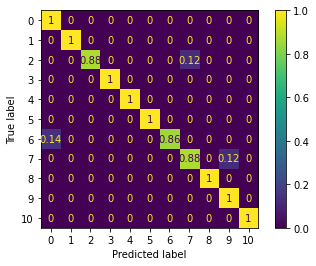

In [203]:
model.evaluate(X_test, y_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model.predict(X_test)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Prepare Model for TensorFlowLite on PocketBeagle

In [192]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (Dense)                 (None, 1024)              1180672   
_________________________________________________________________
dropout_51 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_52 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_53 (Dropout)         (None, 1024)              0         
_________________________________________________________________
result (Dense)               (None, 11)              

Convert TF model to TFLite model

In [193]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmpe0py4zwf\assets


INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmpe0py4zwf\assets


Verify TensorFlowLite model works

In [198]:
interpreter = tf.lite.Interpreter(model_path='test_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)

[{'name': 'data_input', 'index': 0, 'shape': array([   1, 1152]), 'shape_signature': array([  -1, 1152]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [161]:
testing_size = X_test[0].size
testing_size

1152

In [162]:
X_test[46]

array([0.27108055, 0.60922673, 0.45772752, ..., 0.52093402, 0.48902781,
       0.58226719])

In [163]:
#Sometimes behaves weird if no resizing of array 
input_data = np.float32(np.resize(X_test[0], (1, testing_size)))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(np.round(output_data, decimals=3))
print(y_test)

[[0.    0.033 0.94  0.009 0.    0.    0.    0.018 0.    0.    0.   ]
 [0.    0.    0.    0.    0.998 0.    0.    0.    0.001 0.    0.   ]
 [0.    0.011 0.987 0.001 0.    0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.977 0.012 0.    0.002 0.009 0.   ]
 [0.    0.999 0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.001 0.    0.    0.    0.004 0.    0.958 0.    0.016 0.021 0.   ]
 [0.    0.    0.    0.    0.    0.    0.999 0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.005 0.995 0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.999 0.   ]
 [0.    0.    0.    0.    0.001 0.885 0.05  0.    0.004 0.059 0.   ]
 [0.    0.173 0.004 0.01  0.001 0.001 0.    0.716 0.012 0.083 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.002 0.    0.    0.009 0.956 0.

In [165]:
for i in range(0, 113):
    input_data = np.float32(np.resize(X_test[i], (1, testing_size)))
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

ValueError: Cannot set tensor: Dimension mismatch. Got 1 but expected 32 for dimension 0 of input 0.

In [ ]:
output_lbl = np.argmax(output, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, output_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Train model on full data

In [197]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers, callbacks

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
    )



testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val),
                    verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('hand_model.tflite', 'wb') as f:
  f.write(tflite_model)


Epoch 1/600
14/14 [==============================] - 1s 61ms/step - loss: 2.4458 - sparse_categorical_accuracy: 0.0795 - val_loss: 2.3590 - val_sparse_categorical_accuracy: 0.1566
Epoch 2/600
14/14 [==============================] - 1s 54ms/step - loss: 2.4176 - sparse_categorical_accuracy: 0.1136 - val_loss: 2.3129 - val_sparse_categorical_accuracy: 0.2530
Epoch 3/600
14/14 [==============================] - 1s 51ms/step - loss: 2.3705 - sparse_categorical_accuracy: 0.1250 - val_loss: 2.2712 - val_sparse_categorical_accuracy: 0.2169
Epoch 4/600
14/14 [==============================] - 1s 61ms/step - loss: 2.3019 - sparse_categorical_accuracy: 0.1955 - val_loss: 2.2228 - val_sparse_categorical_accuracy: 0.5301
Epoch 5/600
14/14 [==============================] - 1s 63ms/step - loss: 2.2629 - sparse_categorical_accuracy: 0.2068 - val_loss: 2.1623 - val_sparse_categorical_accuracy: 0.4217
Epoch 6/600
14/14 [==============================] - 1s 44ms/step - loss: 2.2068 - sparse_categorica

14/14 [==============================] - 1s 36ms/step - loss: 0.0879 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.1088 - val_sparse_categorical_accuracy: 0.9759
Epoch 91/600
14/14 [==============================] - 1s 40ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.1226 - val_sparse_categorical_accuracy: 0.9759
Epoch 92/600
14/14 [==============================] - 1s 40ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.1637 - val_sparse_categorical_accuracy: 0.9639
Epoch 93/600
14/14 [==============================] - 1s 39ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.1793 - val_sparse_categorical_accuracy: 0.9759
Epoch 94/600
14/14 [==============================] - 1s 40ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.1310 - val_sparse_categorical_accuracy: 0.9759
Epoch 95/600
14/14 [==============================] - 1s 39ms/step - loss: 0.0691 - sparse_categorical_accur

INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmp4uk4i7m8\assets


In [ ]:
model.evaluate(X_val, y_val)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model.predict(X_val)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_val

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()